In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler


In [2]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [3]:
df = pd.read_csv("toniot_event_scores_with_drift.csv")

print("Loaded events:", df.shape)
df.head()


Loaded events: (211043, 50)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,weird_addl,weird_notice,label,type,event_anomaly_score,top_anomalous_features,baseline_id,rolling_anomaly_mean,rolling_anomaly_std,drift_flag
0,192.168.1.37,38211,192.168.1.193,445,tcp,-,0.0,0,0,RSTRH,...,-,-,1,ransomware,0.002394,"['packet_count_log', 'flow_duration_log']",ae_global_v2,NaN,NaN,False
1,192.168.1.37,39083,192.168.1.193,445,tcp,-,0.0,0,0,RSTRH,...,-,-,1,ransomware,0.002394,"['packet_count_log', 'flow_duration_log']",ae_global_v2,NaN,NaN,False
2,192.168.1.37,39083,192.168.1.193,445,tcp,-,0.0,0,0,OTH,...,-,-,1,ransomware,0.002394,"['packet_count_log', 'flow_duration_log']",ae_global_v2,NaN,NaN,False
3,192.168.1.37,39083,192.168.1.193,445,tcp,-,0.0,0,0,OTH,...,-,-,1,ransomware,0.002394,"['packet_count_log', 'flow_duration_log']",ae_global_v2,NaN,NaN,False
4,192.168.1.133,5353,224.0.0.251,5353,udp,dns,0.0,0,0,S0,...,-,-,0,normal,0.002603,"['packet_count_log', 'traffic_volume_log']",ae_global_v2,NaN,NaN,False


In [5]:
# Recreate unified behavioral features for GRU
df = df.copy()

total_bytes = df["src_bytes"] + df["dst_bytes"]
total_pkts  = df["src_pkts"] + df["dst_pkts"]

df["flow_duration_log"] = np.log1p(df["duration"])
df["traffic_volume_log"] = np.log1p(total_bytes)
df["packet_count_log"]  = np.log1p(total_pkts)

df["traffic_rate_log"] = np.log1p(
    total_bytes / (df["duration"] + 1e-6)
)

df["protocol_tcp"] = (df["proto"].str.lower() == "tcp").astype(int)
df["protocol_udp"] = (df["proto"].str.lower() == "udp").astype(int)
df["protocol_http"] = df["proto"].str.lower().isin(["http", "https"]).astype(int)


In [6]:
SEQUENCE_FEATURES = [
    "flow_duration_log",
    "traffic_volume_log",
    "traffic_rate_log",
    "packet_count_log",
    "protocol_tcp",
    "protocol_udp",
    "protocol_http"
]

X = df[SEQUENCE_FEATURES].values


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
def build_sequences(data, window_size=10):
    sequences = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        sequences.append(seq)
    return np.array(sequences)

WINDOW_SIZE = 10

X_seq = build_sequences(X_scaled, WINDOW_SIZE)

print("Sequence shape:", X_seq.shape)


Sequence shape: (211033, 10, 7)


In [9]:
y_event = df["label"].values

benign_idx = np.where(y_event == 0)[0]
benign_idx = benign_idx[benign_idx < len(X_scaled) - WINDOW_SIZE]

X_seq_benign = X_seq[benign_idx]

print("Benign sequences:", X_seq_benign.shape)


Benign sequences: (49999, 10, 7)


In [10]:
timesteps = X_seq_benign.shape[1]
features = X_seq_benign.shape[2]

inputs = Input(shape=(timesteps, features))

x = GRU(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = GRU(32)(x)

x = Dense(32, activation="relu")(x)
x = Dense(features)(x)

model = Model(inputs, x)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 10, 64)         │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,711 (96.53 KB)

 Trainable params: 24,711 (96.53 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_seq_benign,
    X_seq_benign[:, -1, :],  # predict last step
    epochs=25,
    batch_size=128,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.1082 - val_loss: 1.1515
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0083 - val_loss: 1.1203
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0055 - val_loss: 1.0886
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0040 - val_loss: 1.0567
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0032 - val_loss: 1.0274
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0025 - val_loss: 1.0072
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0020 - val_loss: 0.9940
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0017 - val_loss: 0.9949
Epoch 9/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0014 - val_loss: 0.9970
Epoch 10/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0011 - val_loss: 1.0094
Epoch 11/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 8.7545e-04 - val_loss: 1.0113
Epoch 12/25
352/352 ━━━━━━━━━━━━━━━━

In [12]:
X_pred = model.predict(X_seq)

seq_errors = np.mean(
    np.square(X_pred - X_seq[:, -1, :]),
    axis=1
)

seq_scores = (seq_errors - seq_errors.min()) / (
    seq_errors.max() - seq_errors.min()
)

df_seq = df.iloc[WINDOW_SIZE:].copy()
df_seq["sequence_anomaly_score"] = seq_scores


6595/6595 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step


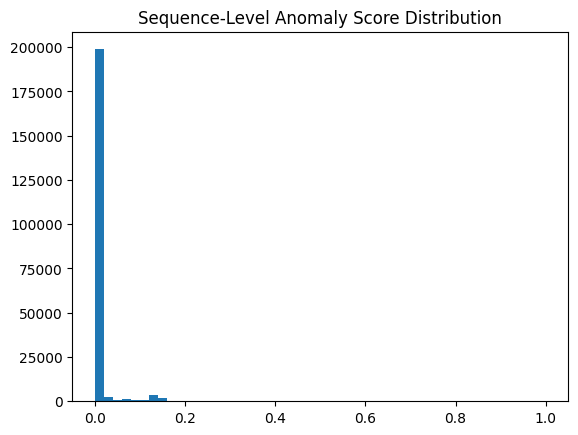

In [13]:
plt.hist(seq_scores, bins=50)
plt.title("Sequence-Level Anomaly Score Distribution")
plt.show()


## Neural Detection Layer — Fusion & Final Scoring


In [14]:
# Align event-level dataframe with sequence outputs
df_fusion = df.iloc[WINDOW_SIZE:].copy()

print("Fusion dataframe shape:", df_fusion.shape)


Fusion dataframe shape: (211033, 57)


In [16]:
df_fusion["sequence_anomaly_score"] = seq_scores

df_fusion[
    ["event_anomaly_score", "sequence_anomaly_score"]
].head()


,event_anomaly_score,sequence_anomaly_score
10,0.002603,1.044067e-06
11,0.002603,3.104635e-06
12,0.002394,4.276221e-06
13,0.002394,1.019290e-06
14,0.002394,9.440002e-07


In [17]:
def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

df_fusion["event_score_norm"] = min_max_norm(
    df_fusion["event_anomaly_score"]
)

df_fusion["sequence_score_norm"] = min_max_norm(
    df_fusion["sequence_anomaly_score"]
)


In [19]:
ALPHA = 0.6   # Event-level importance
BETA  = 0.4   # Sequence-level importance

df_fusion["final_anomaly_score"] = (
    ALPHA * df_fusion["event_score_norm"] +
    BETA  * df_fusion["sequence_score_norm"]
)


In [22]:
# Quantile-based thresholding for operational trade-off
QUANTILES = [0.99, 0.995, 0.999]

print("Anomaly detection trade-off (threshold vs alerts):\n")

for q in QUANTILES:
    threshold = df_fusion["final_anomaly_score"].quantile(q)
    alert_count = (df_fusion["final_anomaly_score"] > threshold).sum()
    print(
        f"Quantile {q:.3f} | "
        f"Threshold = {threshold:.4f} | "
        f"Alerts = {alert_count}"
    )


Anomaly detection trade-off (threshold vs alerts):

Quantile 0.990 | Threshold = 0.0849 | Alerts = 2111
Quantile 0.995 | Threshold = 0.0889 | Alerts = 1056
Quantile 0.999 | Threshold = 0.1515 | Alerts = 212


In [24]:
# Choose operational threshold
SELECTED_QUANTILE = 0.995

THRESHOLD = df_fusion["final_anomaly_score"].quantile(SELECTED_QUANTILE)

df_fusion["is_anomalous"] = (
    df_fusion["final_anomaly_score"] > THRESHOLD
)

print(
    f"Selected Quantile: {SELECTED_QUANTILE} | "
    f"Threshold: {THRESHOLD:.4f}"
)

df_fusion["is_anomalous"].value_counts()


Selected Quantile: 0.995 | Threshold: 0.0889


is_anomalous
False    209977
True       1056
Name: count, dtype: int64

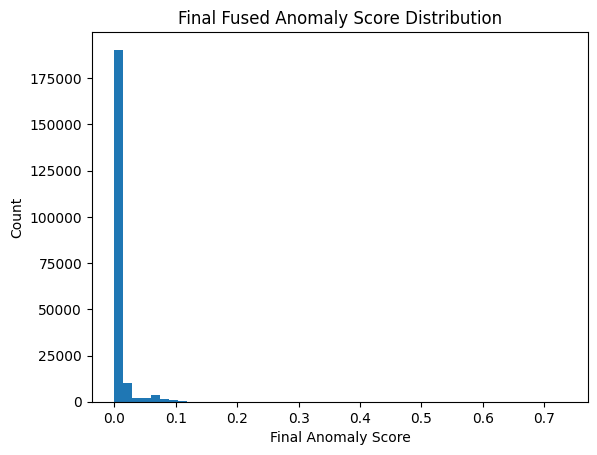

In [25]:
plt.hist(df_fusion["final_anomaly_score"], bins=50)
plt.title("Final Fused Anomaly Score Distribution")
plt.xlabel("Final Anomaly Score")
plt.ylabel("Count")
plt.show()


In [26]:
df_fusion.to_csv(
    "neural_detection_output.csv",
    index=False
)

print("Neural detection output saved")


Neural detection output saved
